## Final Task:
This is your final evaluation for the project. As decided, we will be predicting images of people into three classes: `without_mask`, `mask_weared_incorrect` and `with_mask`. 

In [359]:
import tensorflow as tf

### Loading the dataset
Make a copy of the dataset given to you in your Google Drive (keep it outside, don't put it in any folder to avoid inconvenience). Ensure it is named as `Mask_Dataset` or change the path (the variable `data_dir`) accordingly.

In [360]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [361]:
import pathlib

path='/content/drive/MyDrive/Mask_Dataset/'
data_dir = pathlib.Path(path)

In [362]:
data_dir

PosixPath('/content/drive/MyDrive/Mask_Dataset')

### Know the Dataset
Most of the code is written for you as you aren't used to these libraries. You are to go through the documentation for your benefit.

In [363]:
# Print image count
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8982


In [364]:
# Print Output Labels
import os
output_classes = os.listdir(data_dir)
print(output_classes)

['without_mask', 'mask_weared_incorrect', 'with_mask']


[2994, 2994, 2994]


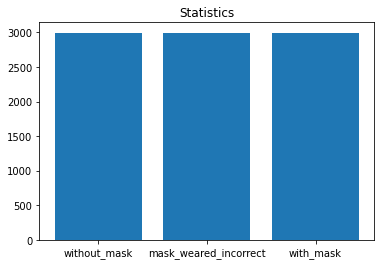

In [365]:
# Plot count of each ouput label
import matplotlib.pyplot as plt

count=[]
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count=os.listdir(dir)
  count.append(len(im_count))

print(count)

plt.bar(output_classes,count)
plt.title("Statistics")
plt.show()

In [366]:
# Check some sample images (Use of cv2)
import cv2
from google.colab.patches import cv2_imshow
mask_info={
    'without_mask':list(data_dir.glob('without_mask/*')),
    'mask_weared_incorrect':list(data_dir.glob('mask_weared_incorrect/*')),
    'with_mask':list(data_dir.glob('with_mask/*')),
}
mask_label={
    'without_mask':0,
    'mask_weared_incorrect':1,
    'with_mask': 2,
}

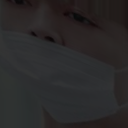

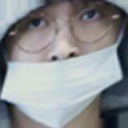

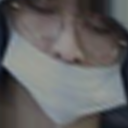

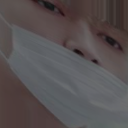

In [367]:
img=cv2.imread(str(mask_info['mask_weared_incorrect'][0]))
for i in range(4):
  img=cv2.imread(str(mask_info['mask_weared_incorrect'][i]))
  cv2_imshow(img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
cv2.destroyAllWindows()

In [368]:
# Check shape of the images in your dataset. This will be helpful while specifying input_shape in your Transfer Learning Model
for i in mask_info:
  for j in range(5):
    img=cv2.imread(str(mask_info[i][j]))
    print(img.shape)


(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


In [369]:
# Check if all the images have same shape, else you need to resize them to some common size
a,b=[],[]
b=(128,128,3)
for i in mask_info:
  for j in range(2994):
    img=cv2.imread(str(mask_info[i][j]))
    a=img.shape
    if(a!=b):
      print("not same shape")
      break;
print("same shape")
# The code provided as it is above in the template will help 

same shape


In [370]:
# # If the shape is variable, reshape to a common size 
# import numpy as np
# x,y=[],[]
# for i,j in mask_info.items():
#   for k in j:
#     img=cv2.imread(str(k))
#     resized_img=cv2.resize(img,(224,224))
#     x.append(resized_img)
#     y.append(mask_label[i])
# x=np.array(x)
# y=np.array(y)
# # If it is same, prove it

In [371]:
# # Anything else you want to plot/experiment
# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)


In [372]:
# x_train=x_train/255
# x_test=x_test/255 

### Model Definition
Choose a model for Transfer Learning (You may also experment with multiple models and keep all of them in this notebook)

In [397]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras import layers

In [398]:
# Choose and define base model
# Create the base model from the pre-trained model ResNet50
IMG_SIZE=(224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [399]:
# Print base model summary and have a look at the layers
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [400]:
# As we're using Transfer Learning, you do not need to train all the layers. Freeze all of the layers or train some layers (experiment)
base_model.trainable=False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [401]:
# Append Fully connected/custom Conv2D/Dropout/MaxPooling layers to the base model
model=keras.Sequential([base_model,layers.Flatten(),
                        layers.Dense(128,activation='relu'),
                        layers.Dense(64,activation='relu'),
                        layers.Dense(16,activation='relu')])

In [402]:
# Add the final output layer
model.add(layers.Dense(3,activation='softmax'))

In [403]:
# Print your model's summary
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_20 (Flatten)        (None, 100352)            0         
                                                                 
 dense_102 (Dense)           (None, 128)               12845184  
                                                                 
 dense_103 (Dense)           (None, 64)                8256      
                                                                 
 dense_104 (Dense)           (None, 16)                1040      
                                                                 
 dense_105 (Dense)           (None, 3)                 51        
                                                                 
Total params: 36,442,243
Trainable params: 12,854,531

In [404]:
# Compile you model (set the parameters like loss/optimizers/metrics)
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = "accuracy")

### Data Augmentation and Pre-processing
Augment the data. You may also try dyanamic augmentation using [`tf.keras.preprocessing.image.ImageDataGenerator `](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).   
You may use [`tf.keras.applications.vgg16.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)(or some other base model's utility) for pre-processing (can also be passed as a parameter to `ImageDataGenerator`)

In [405]:
from keras.applications.vgg16 import preprocess_input # Change according to your base model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_new =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.30,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
    )
# Your code 

### Training and Validation Dataset  
Split the dataset into training and validation (We'll be looking for your validation accuracy, assume we are using complete dataset for now). 

Hint: `flow_from_directory` used with `ImageDataGenerator` will simplify things for you.

In [406]:
# Your code

train_ds=image_new.flow_from_directory(path,
                                   target_size=(224,224),
                                   color_mode='rgb',
                                   batch_size=128,
                                   class_mode='categorical')

val_ds=image_new.flow_from_directory(path,
                                  target_size=(224,224),
                                  color_mode='rgb',
                                  batch_size=128,
                                  class_mode='categorical',
                                  subset='validation')
# Your code

Found 8982 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


### Training  
Train your model for some epochs and plot the graph. Try and save your best model. Experiment with the parameters of `model.fit`

In [407]:
from keras.callbacks import ModelCheckpoint
history= model.fit(train_ds,validation_data=val_ds,epochs=10)
# ModelCheckpoint is helpful to save the model giving best results (brownie points)

Epoch 1/10
71/71 [==============================] - 155s 2s/step - loss: 0.9335 - accuracy: 0.8733 - val_loss: 0.2035 - val_accuracy: 0.9448
Epoch 2/10
71/71 [==============================] - 149s 2s/step - loss: 0.1506 - accuracy: 0.9578 - val_loss: 0.1326 - val_accuracy: 0.9671
Epoch 3/10
71/71 [==============================] - 148s 2s/step - loss: 0.1239 - accuracy: 0.9650 - val_loss: 0.1647 - val_accuracy: 0.9571
Epoch 4/10
71/71 [==============================] - 148s 2s/step - loss: 0.1078 - accuracy: 0.9693 - val_loss: 0.1203 - val_accuracy: 0.9643
Epoch 5/10
71/71 [==============================] - 149s 2s/step - loss: 0.0828 - accuracy: 0.9736 - val_loss: 0.0566 - val_accuracy: 0.9849
Epoch 6/10
71/71 [==============================] - 147s 2s/step - loss: 0.0844 - accuracy: 0.9755 - val_loss: 0.0542 - val_accuracy: 0.9822
Epoch 7/10
71/71 [==============================] - 148s 2s/step - loss: 0.0702 - accuracy: 0.9801 - val_loss: 0.0424 - val_accuracy: 0.9861
Epoch 8/10
71

### Evaluate the performance

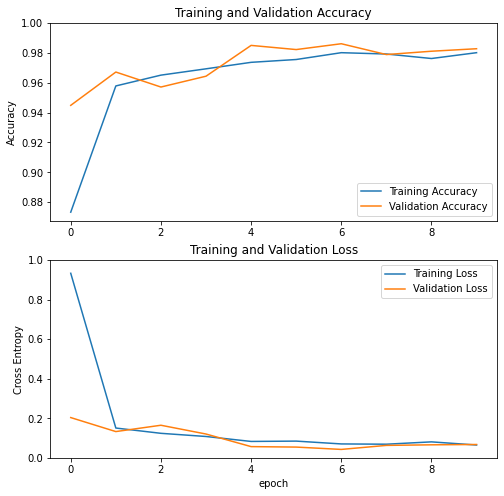

In [408]:
# Plot training & validation loss/accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [409]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
validation_classes = []
validation_images = []
for i in range( -(-val_ds.samples // val_ds.batch_size)):
        batch = val_ds.next()
        expected = np.argmax(batch[1], axis=1)
        validation_classes.extend(expected)
        validation_images.extend(batch[0])
validation_classes = np.array(validation_classes)
validation_images = np.array(validation_images)
Y_pred = model.predict(validation_images)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(validation_classes, y_pred,target_names = ['without_mask', 'mask_weared_incorrect', 'with_mask']))
# print classification report

                       precision    recall  f1-score   support

         without_mask       0.98      0.99      0.98       598
mask_weared_incorrect       0.99      0.97      0.98       598
            with_mask       0.99      1.00      0.99       598

             accuracy                           0.99      1794
            macro avg       0.99      0.99      0.99      1794
         weighted avg       0.99      0.99      0.99      1794

